# Task 2 - Paddy Variety Classification using MobileNetV2

## Importing Required Libraries

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Flatten, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras_tuner import HyperParameters
import keras_tuner as kt
from tensorflow import keras
import tensorflow as tf

2025-05-11 15:12:40.639883: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746976361.039792      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746976361.155344      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Data Augmentation
- Use `ImageDataGenerator` for data augmentation with techniques like rotation, zoom, brightness adjustment, and horizontal flipping.  
- Rescale validation data without applying augmentation.  

In [ ]:
# Define directories for training and validation datasets
train_dir = '/kaggle/input/task2_tomek_smote/train'
val_dir = '/kaggle/input/task2_tomek_smote/val'

# Data augmentation for training dataset
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Training data generator
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Rescaling for validation dataset
val_test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Validation data generator
val_generator = val_test_datagen.flow_from_directory(
    directory=val_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

# Fetch a batch of training data
x_batch, y_batch = next(train_generator)

Found 21289 images belonging to 10 classes.
Found 2071 images belonging to 10 classes.


## Model Building
The `custom_mobnetv2` function is defined to build a MobileNetV2-based deep learning model for multi-class classification. Key features of the model include:
- **Base Architecture**: MobileNetV2 is used as the backbone, initialized without pre-trained weights to allow training from scratch.
- **Global Average Pooling**: The output of the base model is passed through a global average pooling layer to reduce dimensionality.
- **Dense Blocks**: Two fully connected (dense) layers are added, with tunable hyperparameters for:
    - The number of units in each layer.
    - Dropout rates to prevent overfitting.
    - Batch normalization and ReLU activation for improved training stability and non-linearity.
- **Output Layer**: A softmax-activated dense layer is used to predict probabilities for each class.
- **Compilation**: The model is compiled with the Adam optimizer, categorical crossentropy loss, and accuracy as the evaluation metric.

Additionally, callbacks and the Keras Tuner are employed to enhance training efficiency and model performance:
- **Early Stopping**: Implemented to monitor validation accuracy and stop training when it stops improving, restoring the best weights to prevent overfitting.  
- **Learning Rate Reduction**: A callback to reduce the learning rate when the validation loss plateaus, improving convergence.  
- **Hyperparameter Tuning**: Keras Tuner's Bayesian Optimization is used to search for the best hyperparameters, optimizing validation accuracy over multiple trials.  

In [ ]:
def custom_mobnetv2(hp):
    """
    Constructs a MobileNetV2 model with tunable hyperparameters.
    Args:
        hp: Keras Tuner HyperParameters object for hyperparameter tuning.
    Returns:
        model: A compiled Keras model ready for training.
    """
    base_model = MobileNetV2(
        weights=None,  # Train from scratch
        include_top=False,
        input_shape=(224, 224, 3)
    )

    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # Dense Block 1
    x = Dense(hp.Int('dense1_units', min_value=256, max_value=1024, step=256))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(hp.Float('dropout_rate1', min_value=0.2, max_value=0.5, step=0.1))(x)

    # Dense Block 2
    x = Dense(hp.Int('dense2_units', min_value=128, max_value=512, step=64))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(hp.Float('dropout_rate2', min_value=0.1, max_value=0.4, step=0.1))(x)

    # Output Layer (assuming 10 classes)
    outputs = Dense(10, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=outputs)

    # Compile the model with Adam optimizer and categorical crossentropy loss
    model.compile(
        optimizer=Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 5e-4, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1,
    min_lr=1e-6
)

# Bayesian Optimization for hyperparameter tuning
tuner = kt.BayesianOptimization(
    custom_mobnetv2,
    objective='val_accuracy',
    max_trials=10,
    directory='kt_bayesian',
    project_name='rice_variety_tuning_mobilenetv2'
)

I0000 00:00:1746976391.912919      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746976391.913594      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


## Hyperparameter Tuning
Using Keras Tuner's Bayesian Optimization, I search for the best hyperparameters for the model. The tuning process optimizes for validation accuracy over a specified number of trials.

In [ ]:
tuner.search(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hps.values}")

Trial 4 Complete [00h 29m 50s]
val_accuracy: 0.6692419052124023

Best val_accuracy So Far: 0.9642684459686279
Total elapsed time: 03h 09m 36s

Search: Running Trial #5

Value             |Best Value So Far |Hyperparameter
1024              |256               |dense1_units
0.4               |0.3               |dropout_rate1
256               |384               |dense2_units
0.1               |0.2               |dropout_rate2
0.01              |0.001             |learning_rate

Epoch 1/20
144/666 ━━━━━━━━━━━━━━━━━━━━ 3:32 407ms/step - accuracy: 0.3122 - loss: 2.0931

## Training the Best Model

In [5]:
best_hps = HyperParameters()
best_hps.Fixed('dense1_units', 384)
best_hps.Fixed('dropout_rate1', 0.3)
best_hps.Fixed('dense2_units', 256)
best_hps.Fixed('dropout_rate2', 0.2)
best_hps.Fixed('learning_rate', 0.001)

# Rebuild the best model
final_model = tuner.hypermodel.build(best_hps)

# Fit the best model with callbacks
mobnetv2 = final_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/25
666/666 ━━━━━━━━━━━━━━━━━━━━ 361s 457ms/step - accuracy: 0.3909 - loss: 1.8384 - val_accuracy: 0.0637 - val_loss: 1.8676 - learning_rate: 0.0010
Epoch 2/25
666/666 ━━━━━━━━━━━━━━━━━━━━ 283s 420ms/step - accuracy: 0.4800 - loss: 1.4777 - val_accuracy: 0.0386 - val_loss: 1.8473 - learning_rate: 0.0010
Epoch 3/25
666/666 ━━━━━━━━━━━━━━━━━━━━ 282s 420ms/step - accuracy: 0.5492 - loss: 1.2905 - val_accuracy: 0.6692 - val_loss: 1.6500 - learning_rate: 0.0010
Epoch 4/25
666/666 ━━━━━━━━━━━━━━━━━━━━ 278s 413ms/step - accuracy: 0.6017 - loss: 1.1325 - val_accuracy: 0.6692 - val_loss: 1.5288 - learning_rate: 0.0010
Epoch 5/25
666/666 ━━━━━━━━━━━━━━━━━━━━ 281s 418ms/step - accuracy: 0.6572 - loss: 0.9870 - val_accuracy: 0.6692 - val_loss: 1.7327 - learning_rate: 0.0010
Epoch 6/25
666/666 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.6974 - loss: 0.8705
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
666/666 ━━━━━━━━━━━━━━━━━━━━ 278s 414ms/step - accuracy:

## Performance Evaluation

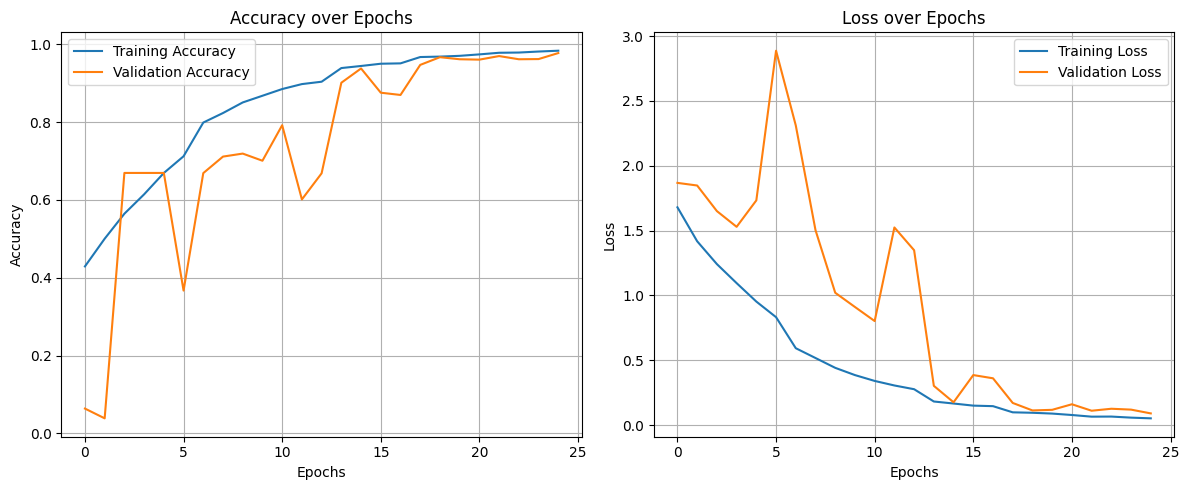

In [7]:
# Plot accuracy
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(mobnetv2.history['accuracy'], label='Training Accuracy')
plt.plot(mobnetv2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(mobnetv2.history['loss'], label='Training Loss')
plt.plot(mobnetv2.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Save the trained model to a file
final_model.save("best_mobnetv2_model.h5")

 ## Making Predictions and Exporting Results

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def predict_and_export(model_path, image_dir, output_csv, target_size=(224, 224)):
    """
    Predicts the class of images in a directory using a trained model and exports results to a CSV file.
    Args:
        model_path (str): Path to the trained model.
        image_dir (str): Directory containing images to predict.
        output_csv (str): Path to save the output CSV file.
        target_size (tuple): Target size for image resizing.
    """
    # Load the trained model
    model = load_model(model_path)

    # Get class labels from model if needed 
    class_labels = list(train_generator.class_indices.keys())

    predictions = []

    for fname in sorted(os.listdir(image_dir)):
        if fname.lower().endswith('.jpg'):
            fpath = os.path.join(image_dir, fname)

            # Preprocess image
            img = load_img(fpath, target_size=target_size)
            img_arr = img_to_array(img) / 255.0
            img_arr = np.expand_dims(img_arr, axis=0)

            # Predict
            probs = model.predict(img_arr, verbose=0)
            predicted_class = class_labels[np.argmax(probs)]

            predictions.append({
                'filename': fname,
                'predicted_label': predicted_class
            })

    # Export to CSV
    df = pd.DataFrame(predictions)
    df.to_csv(output_csv, index=False)
    print(f"[✓] Predictions saved to: {output_csv}")

# Usage
predict_and_export(
    model_path='best_mobnetv2_model.h5',
    image_dir='/kaggle/input/train-images/test_images',
    output_csv='variety_predictions.csv'
)

[✓] Predictions saved to: variety_predictions.csv
